<a href="https://colab.research.google.com/github/aryamansriram/Hateful_Memes/blob/master/Hateful_Memes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hateful Memes Network
This is an attempt at modelling networks to solve two problems:

a) Classifying whether a meme is hateful/dank or not

b) Generating a caption for a meme by looking at the image

**1. Mount drive file structure**

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**2. Unzip the zipped folder**

In [ ]:
!unzip gdrive/My\ Drive/Hateful\ Memes.zip
#import os
#os.listdir("gdrive/My Drive")

**3. Unzip the image files**

In [ ]:
!tar -xvf /content/Hateful\ Memes/data/img.tar.gz

**4. Extract the text from json into a dataframe**

In [ ]:
import json
with open("/content/Hateful Memes/data/train.jsonl") as f:
  arr_train = f.readlines()


In [ ]:
import json
with open("/content/Hateful Memes/data/test.jsonl") as f:
  arr_test = f.readlines()


In [ ]:
import json
with open("/content/Hateful Memes/data/dev.jsonl") as f:
  arr_dev = f.readlines()


In [ ]:
def read_data(arr):
  '''Reads data from an array of records into a dataframe
  Input: arr: Array of records
  Output: Dataframe of all features'''

  df = {}
  df["id"] = []
  df["img_name"] = []
  df["label"] =[]
  df["text"] = []
  print("Starting extraction....")
  for element in arr:
    js = json.loads(element)

    id = js["id"]
    
    img_name = js["img"]
    
    label = js["label"]
    text = js["text"]
    
    df["id"].append(id)
    df["img_name"].append(img_name)
    df["label"].append(label)
    df["text"].append(text)
  print("Extraction over...")

  return df  

In [ ]:
def read_data_test(arr):
  '''Reads data from an array of records into a dataframe
  Input: arr: Array of records
  Output: Dataframe of all features'''

  df = {}
  df["id"] = []
  df["img_name"] = []
  
  df["text"] = []
  print("Starting extraction....")
  for element in arr:
    js = json.loads(element)

    id = js["id"]
    
    img_name = js["img"]
    
    
    text = js["text"]
    
    df["id"].append(id)
    df["img_name"].append(img_name)
    df["text"].append(text)
  print("Extraction over...")

  return df  

In [ ]:
import pandas as pd
train_data_dict = read_data(arr_train)
test_data_dict = read_data_test(arr_test)
dev_data_dict = read_data(arr_dev)
train_dataframe = pd.DataFrame(train_data_dict)

train_dataframe.head()

Starting extraction....
Extraction over...
Starting extraction....
Extraction over...
Starting extraction....
Extraction over...


,id,img_name,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [ ]:
dev_dataframe = pd.DataFrame(dev_data_dict)
dev_dataframe.head()

,id,img_name,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


In [ ]:
test_dataframe = pd.DataFrame(test_data_dict)
test_dataframe.head()

,id,img_name,text
0,16395,img/16395.png,handjobs sold seperately
1,37405,img/37405.png,introducing fidget spinner for women
2,94180,img/94180.png,happy pride month let's go beat up lesbians
3,54321,img/54321.png,laughs in [majority of u.s crime rate]
4,97015,img/97015.png,finds out those 72 virgins.. are goats


**6. Display the images**

In [ ]:
import matplotlib.pyplot as plt
import cv2
def img_plotter():
  fig,ax = plt.subplots(5,5,figsize=(30,30))
  
  for i in range(5):
    for j in range(5):
      b,g,r = cv2.split(cv2.imread(train_dataframe["img_name"].values[5*i+j]))
      ax[i,j].imshow(cv2.merge([r,g,b]))

  

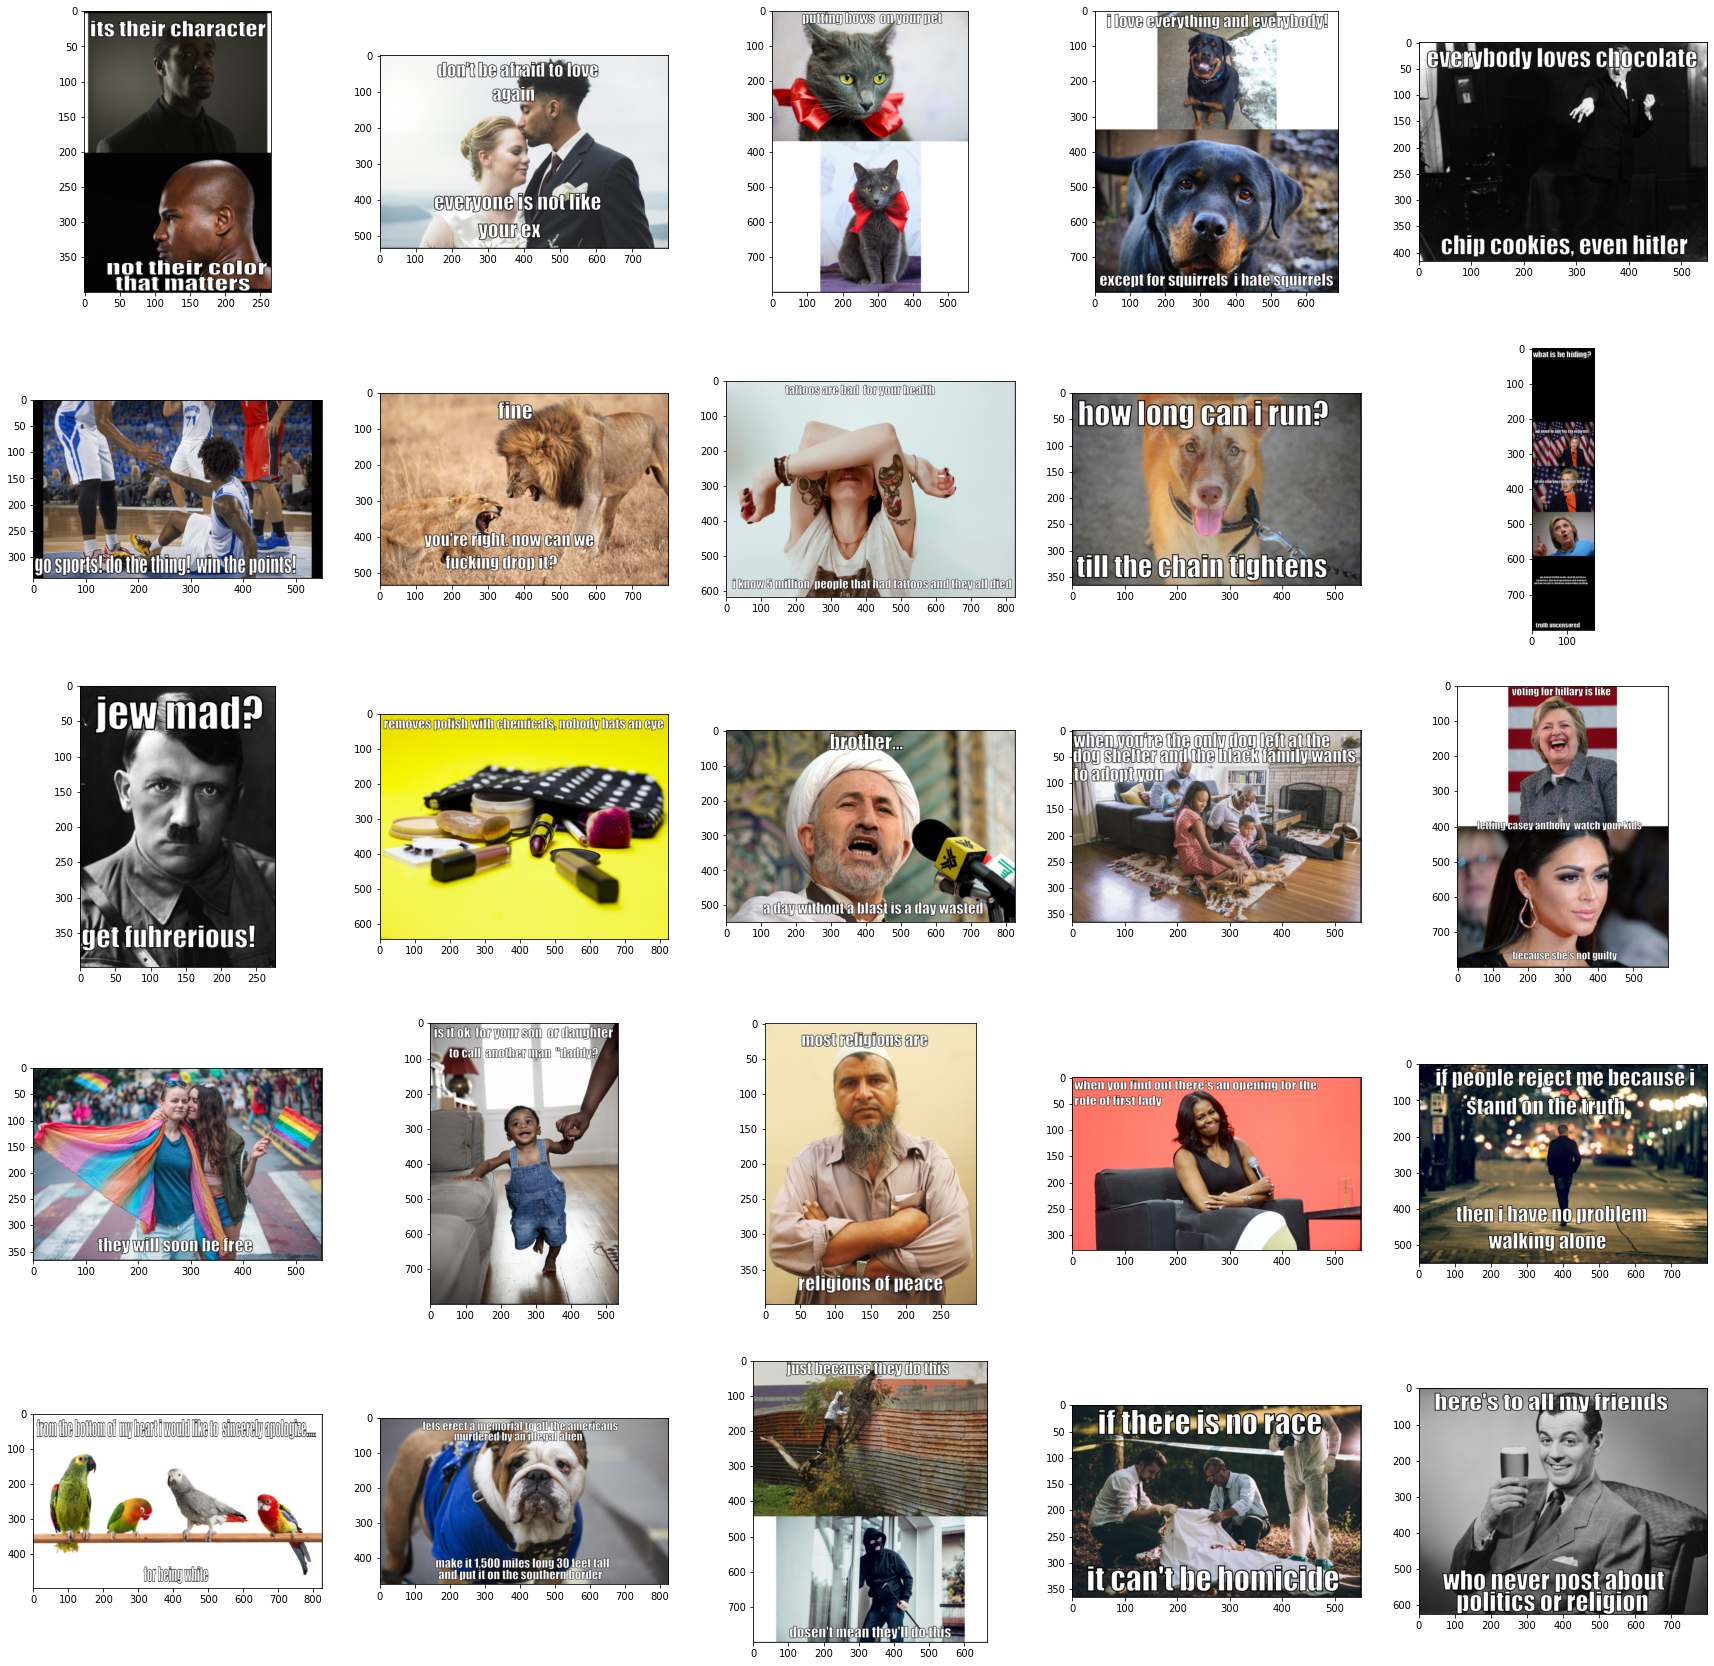

In [ ]:
img_plotter()

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer,BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#bert = BertModel.from_pretrained('bert-base-uncased')


**7. Create the dataset class for the dataset**

In [ ]:
import numpy as np
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import torch
import cv2
from keras_preprocessing.sequence  import pad_sequences

class Meme_Dataset(Dataset):
  '''Meme dataset custom class
  args: 
  '''
  
  def __init__(self,csv,transforms=None):
    self.csv = csv
    
    self.transforms = transforms
  
  def __len__(self):
    return len(self.csv)
  
  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx.to_list()
    req = self.csv.iloc[idx]
    img_name = req.img_name
    img_label = [req.label]
    text = req.text
    encoding = tokenizer.encode(text)
    #print(encoding)
    encoding = pad_sequences([encoding],maxlen=20,padding="post")
    mask = encoding.copy()
    mask[mask>0] = 1
    #embedding =  bert(input_ids=torch.LongTensor(encoding).squeeze(1))[0]
    img = cv2.imread(img_name)
    if self.transforms:
      img = self.transforms(img)

    sample = {"image":img,"label":torch.FloatTensor(img_label),"text":text,"embeddings":torch.LongTensor(encoding),"attn":torch.FloatTensor(mask)}
    
    return sample


In [ ]:
import numpy as np
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import torch
import cv2
from keras_preprocessing.sequence  import pad_sequences

class Meme_Dataset_Test(Dataset):
  '''Meme dataset custom class
  args: 
  '''
  
  def __init__(self,csv,transforms=None):
    self.csv = csv
    
    self.transforms = transforms
  
  def __len__(self):
    return len(self.csv)
  
  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx.to_list()
    req = self.csv.iloc[idx]
    img_name = req.img_name
    
    text = req.text
    encoding = tokenizer.encode(text)
    #print(encoding)
    encoding = pad_sequences([encoding],maxlen=20,padding="post")
    mask = encoding.copy()
    mask[mask>0] = 1
    #embedding =  bert(input_ids=torch.LongTensor(encoding).squeeze(1))[0]
    img = cv2.imread(img_name)
    if self.transforms:
      img = self.transforms(img)

    sample = {"image":img,"text":text,"embeddings":torch.LongTensor(encoding),"attn":torch.FloatTensor(mask)}
    
    return sample


**8. Set up transforms**

In [ ]:
transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize((224,224)),transforms.ToTensor()])
meme_dataset = Meme_Dataset(train_dataframe,transform)
sample = meme_dataset[0]
#sample["embeddings"].size()
sample["attn"].size()

torch.Size([1, 20])

In [ ]:
sample["embeddings"]

In [ ]:
sample["attn"]

**9. Split data into train and test and setup dataloaders**

In [ ]:
dataloader = DataLoader(meme_dataset,shuffle=True,batch_size=32)
sample = next(iter(dataloader))

In [ ]:
'''from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(dataframe["img_name"],dataframe["label"],test_size=0.1,random_state=42)
_,_,texts_train,texts_test = train_test_split(dataframe["img_name"],dataframe["text"],test_size=0.1,random_state=42)

train_dict = {"img_name":X_train,"label":Y_train,"text":texts_train}
test_dict = {"img_name":X_test,"label":Y_test,"text":texts_test}

train_csv = pd.DataFrame(train_dict)
val_csv = pd.DataFrame(test_dict)'''

train_dataset = Meme_Dataset(train_dataframe,transforms=transform)
dev_dataset = Meme_Dataset(dev_dataframe,transform)
test_dataset = Meme_Dataset_Test(test_dataframe,transform)

In [ ]:
train_dataloader = DataLoader(train_dataset,shuffle=True,batch_size=8)
dev_dataloader = DataLoader(dev_dataset,shuffle=True,batch_size=8)
test_dataloader = DataLoader(test_dataset,batch_size=8)

**10. Create Baseline**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class Convpart(nn.Module):
  def __init__(self):
    super(Convpart,self).__init__()

    self.block1 = nn.Sequential(nn.Conv2d(3,128,kernel_size=5,padding=2),
                                nn.Conv2d(128,64,kernel_size=5,padding=2),
                                nn.AvgPool2d(kernel_size=3,padding=1))
    self.block2 = nn.Sequential(nn.Conv2d(64,64,kernel_size=5,padding=2),
                                nn.Conv2d(64,32,kernel_size=5,padding=2),
                                nn.MaxPool2d(kernel_size=3,padding=1))
    self.dropout = nn.Dropout(0.7)
    self.block3 = nn.Sequential(nn.Conv2d(32,32,kernel_size=5,padding=2),
                                nn.Conv2d(32,32,kernel_size=5,padding=2),
                                nn.MaxPool2d(kernel_size=3,padding=1))
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(2592,1500)
    
    self.fc2 = nn.Linear(1500,1000)
    
    self.fc3 = nn.Linear(1000,768)
    self.flat = nn.Flatten()

  def forward(self,x):
    x = F.relu(self.block1(x),inplace=False)
    x = F.relu(self.block2(x),inplace=False)
    x = F.relu(self.dropout(self.block3(x)),inplace=False)
    x = self.flat(x)
    x = F.relu(self.fc1(x),inplace=False)
    x = F.relu(self.fc2(x),inplace=False)
    out = self.flat(F.relu(self.fc3(x)))

    return out


    

In [ ]:
from torchvision.models import vgg16,resnet18,mobilenet_v2
vgg = vgg16(pretrained=True)
resnet = resnet18(pretrained=True)
mobilenet = mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
class VGG_Part(nn.Module):
  def __init__(self):
    super(VGG_Part,self).__init__()
    self.model = torch.nn.Sequential(*(list(vgg.children())[:-1]))
    self.pooling = torch.nn.MaxPool2d(kernel_size=3)
    self.flat_layer = nn.Flatten()
    #self.fc = nn.Linear(512*7*7,768)

  def forward(self,x):
    x = self.model(x)
    #print("VGG: ",x.size())
    x = self.pooling(x)
    out = self.flat_layer(x)
    #out = self.
    return out

In [ ]:
class Resnet_Part(nn.Module):
  def __init__(self):
    super(Resnet_Part,self).__init__()
    self.model = torch.nn.Sequential(*(list(resnet.children())[:-1]))
    self.pooling = torch.nn.MaxPool2d(kernel_size=3)
    self.flat_layer = nn.Flatten()
    #self.fc = nn.Linear(512*7*7,768)

  def forward(self,x):
    x = self.model(x)
    #print("Resnet: ",x.size())
    #x = self.pooling(x)
    out = self.flat_layer(x)
    #out = self.
    return out

In [ ]:
class MobileNet_Part(nn.Module):
  def __init__(self):
    super(MobileNet_Part,self).__init__()
    self.model = torch.nn.Sequential(*(list(mobilenet.children())[:-1]))
    self.pooling = torch.nn.MaxPool2d(kernel_size=3)
    self.flat_layer = nn.Flatten()
    #self.fc = nn.Linear(512*7*7,768)

  def forward(self,x):
    x = self.model(x)
    #print("Mobile Net: ",x.size())
    x = self.pooling(x)
    out = self.flat_layer(x)
    #out = self.
    return out

In [ ]:
class Ensemble_Block(nn.Module):
  def __init__(self):
    super(Ensemble_Block,self).__init__()
    self.vgg = VGG_Part()
    self.res= Resnet_Part()
    self.mobile = MobileNet_Part()
    self.fc_b1 = nn.Sequential(nn.Linear(7680,6000),
                               nn.BatchNorm1d(6000))
    self.d1 = nn.Dropout(0.6)
    self.fc_b2 = nn.Sequential(nn.Linear(6000,3000),
                               nn.BatchNorm1d(3000))
    self.d2 = nn.Dropout(0.6)
    self.fc3 = nn.Linear(3000,768)

  def forward(self,x):
    x1 = self.vgg(x)
    x2 = self.res(x)
    x3 = self.mobile(x)
    out_1 = torch.cat([x1,x2,x3],dim=1)
    #print("O1: ",out_1.size())
    out_1 = self.d1(self.fc_b1(out_1))
    out_1 = self.d2(self.fc_b2(out_1))
    out = self.fc3(out_1)
    return out


In [ ]:
class BERTpart(nn.Module):
  def __init__(self):
    super(BERTpart,self).__init__()
    #self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.model = BertModel.from_pretrained('bert-base-uncased')
    self.pooling = nn.AvgPool1d(kernel_size=3)
    self.flat_layer = nn.Flatten()
    self.dropout = nn.Dropout(0.6)
    #self.fc1 = nn.Linear(5120,8000)
    #self.fc2 = nn.Linear(8000,3000)
    self.fc3 = nn.Linear(5120,768)
  def forward(self,x,attn):
    #tokens = self.tokenizer.encode(x)
    #tokens = torch.FloatTensor(tokens)
    x =  self.model(input_ids=x.squeeze(1),encoder_attention_mask=attn)[0]
    #x = x.squeeze(1)
    #x = self.model(input_ids=x)
    x = self.pooling(x)
    x = self.flat_layer(x)
    
    
    #x = F.relu(self.fc1(x),inplace=False)
    #x = F.relu(self.dropout(self.fc2(x)),inplace=False)

    out = F.relu(self.fc3(x),inplace=False)
    return out


In [ ]:
class MemeNet(nn.Module):
  def __init__(self):
    super(MemeNet,self).__init__()
    #self.vgg_part = VGG_Part()
    #self.conv_part = Convpart()
    self.bert_part = BERTpart()
    self.batch_norm = nn.BatchNorm1d(6000)
    #self.fc1 = nn.Linear(25856,6000)
    self.ensemble = Ensemble_Block()
    self.fc1 = nn.Linear(1536,6000)
    self.fc2 = nn.Linear(6000,3000)
    self.fc3 = nn.Linear(3000,1)

  def forward(self,image,text,attn):
    #x1 = self.conv_part(image)
    #x1 = self.vgg_part(image)
    x1 = self.ensemble(image)
    x2 = self.bert_part(text,attn)
    #print("O2: ",torch.cat((x1,x2),dim=1).size())
   
    x3 = self.fc1(torch.cat((x1,x2),dim=1))
    x3 = self.batch_norm(x3)
    x4 = F.relu(self.fc2(x3),inplace=False)
    out_1 = self.fc3(x4)
    out = torch.sigmoid(out_1)
    return out




In [ ]:
### freezing bert ####
torch.manual_seed(42)
model = MemeNet()
#model.bert_part.model.requires_grad_ = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

from torch.optim import Adam
#from torch.nn.losses import BCELoss
optim = Adam(model.parameters(),lr=1e-5,weight_decay=0.001)
criterion = nn.BCELoss()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score,recall_score
def metrics(out,label,accuracy=True,precision=False,recall=False):
  arr = out.detach().cpu().numpy()
  mask_0 = arr<0.5
  mask_1 = arr>0.5
  arr[mask_0] = 0
  arr[mask_1] = 1
  lab = label.cpu().numpy()
  
  
  
  ret = []
  if accuracy:
    acc = np.sum(lab == arr)/len(arr)
    ret.append(acc)
  if precision:
    precision = precision_score(arr,lab)
    ret.append(precision)
  if recall:
    recall = recall_score(arr,lab)
    ret.append(recall)
  return ret

In [ ]:
epochs = 3
losses = []
losses_val=[]
for epoch in range(epochs):
  model.train()
  print("===================== Training ====================")
  print("Epoch # ",epoch+1)
  train_loss = 0.0
  train_acc = 0.0
  train_pre = 0.0
  train_rec= 0.0
  for num,batch in enumerate(train_dataloader):
    img,embeddings,label = batch["image"].to(device),batch["embeddings"].to(device),batch["label"].to(device)
    mask = batch["attn"].to(device)
    out = model.forward(img,embeddings,mask)
    
    loss = criterion(out,label)
   
    train_loss+=loss.item()
    [acc,prec,rec] = metrics(out,label,accuracy=True,precision=True,recall=True)
    train_acc+=acc
    train_pre+=prec
    train_rec+=rec
    loss.backward()
    optim.step()
    optim.zero_grad()

    
    
    if num>0 and num%100==0:
      print("Loss after ",num," steps: ",train_loss/num)
      print("Accuracy after ",num," steps: ",train_acc/num)
      print("Precision after ",num," steps: ",train_pre/num)
      print("Recall after ",num," steps: ",train_rec/num)
      
      #print("Actual Output: ",label)
      #print("Predicted Output: ",out)
    
  losses.append(train_loss/len(train_dataloader))
  print("----------------After epoch ",epoch+1,"-------------------------")
  print("Loss after ",num," steps: ",train_loss/num)
  print("Accuracy after ",num," steps: ",train_acc/num)
  print("Precision after ",num," steps: ",train_pre/num)
  print("Recall after ",num," steps: ",train_rec/num)
      
  

  model.eval()
  print("=====================Validating=====================")
  eval_acc = 0.0
  eval_loss = 0.0
  eval_prec = 0.0
  eval_rec = 0.0
  for num,batch in enumerate(dev_dataloader):
    img,embeddings,label = batch["image"].to(device),batch["embeddings"].to(device),batch["label"].to(device)
    mask = batch["attn"].to(device)
    out = model.forward(img,embeddings,mask)
  
    loss = criterion(out,label)

    eval_loss+=loss.item()
    [acc,precision,recall] = metrics(out,label,True,True,True)
    eval_acc+=acc
    eval_prec+=precision 
    eval_rec+=recall
    if num == 5:
      print("Actual Labels: ",label)
      arr = out
      #arr[arr>0.5] = 1
      #arr[arr<0.5] = 0
      print("Predicted Labels",arr)
  print("Val_loss after ",epoch+1," epochs: ",eval_loss/len(dev_dataloader))
  losses_val.append(eval_loss/len(dev_dataloader))
  print("Val_accuracy after ",epoch+1," epochs: ",eval_acc/len(dev_dataloader))
  print("Val_precision after ",epoch+1," epochs: ",eval_prec/len(dev_dataloader))
  print("Val_recall after ",epoch+1," epochs: ",eval_rec/len(dev_dataloader))
  ### Early Stopping
  '''if epoch==0:
    prev_eval_loss=eval_loss
    continue
  if eval_loss>prev_eval_loss:
    break
  else:
    prev_eval_loss = eval_loss'''
  
  
  



    

  
      


In [ ]:
x_epochs = [1,2,3]
import matplotlib.pyplot as plt
plt.plot(x_epochs,losses,linewidth=2.0,label="train_loss")
plt.plot(x_epochs,losses_val,linewidth=2.0,label="val_loss")
plt.title("Loss Comparison")
plt.legend()

In [ ]:
epochs

3

In [ ]:
plt.imshow(np.transpose(img[0].detach().cpu().numpy(),(1,2,0)))
plt.title(label[0].item())

In [ ]:
preds = []
probs = []
for batch in test_dataloader:
  img,embeddings = batch["image"].to(device),batch["embeddings"].to(device)
  out = model.forward(img,embeddings,mask)
  arr = out.detach().cpu().numpy().copy()
  arr[arr<0.5]=0
  arr[arr>0.5]=1
  probs_temp = list(out.detach().cpu().numpy().reshape(1,-1)[0])

  preds_temp = list(arr.reshape(1,-1)[0].astype(int))
  preds.extend(preds_temp)
  probs.extend(probs_temp)
  


In [ ]:
submit = pd.DataFrame({"id":test_dataframe.id,"proba":probs,"label":preds})
submit.head()

,id,proba,label
0,16395,0.967372,1
1,37405,0.207724,0
2,94180,0.959370,1
3,54321,0.697910,1
4,97015,0.712624,1


In [ ]:
sub = pd.read_csv("/content/Hateful Memes/data/submission_format.csv")
sub.head()

,id,proba,label
0,16395,0.4,0
1,37405,0.4,0
2,94180,0.4,0
3,54321,0.4,0
4,97015,0.4,0


In [ ]:
submission = submit.set_index("id")

In [ ]:
submission.to_csv("submission_ensemble_60_val.csv")

#Finetune Roberta for toxic texts

In [1]:
import pandas as pd
toxic_df = pd.read_csv("/content/gdrive/My Drive/toxic_comments.csv")

In [2]:
toxic_df["offensive"] = toxic_df.toxic+toxic_df.severe_toxic+toxic_df.obscene+toxic_df.threat+toxic_df.insult+toxic_df.identity_hate
toxic_df["offensive"]

0         0
1         0
2         0
3         0
4         0
         ..
159566    0
159567    0
159568    0
159569    0
159570    0
Name: offensive, Length: 159571, dtype: int64

In [3]:
arr = toxic_df.offensive.values
arr[arr>0] = 1
req_df = pd.DataFrame({"text": toxic_df.comment_text,"label":arr})

In [4]:
req_df["label"].value_counts()

0    143346
1     16225
Name: label, dtype: int64

In [5]:
### under sampling ###
zs = req_df[req_df["label"]==0]
ons = req_df[req_df["label"]==1]
final_df = pd.concat([zs.iloc[:16225],ons],axis=0)
final_df.head()

,text,label
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
final_df = final_df.sample(frac=1)

In [50]:
!pip install transformers

In [7]:
from transformers import RobertaTokenizerFast,RobertaForSequenceClassification
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")


In [8]:
from torch.utils.data import Dataset,DataLoader
import torch
import numpy as np
max_len=512
class Toxic_Comments(Dataset):
  def __init__(self,dataframe,labels,tokenizer):
    self.dataframe = dataframe
    self.labels = labels
    self.tokenizer = tokenizer
  
  def __len__(self):
    return len(self.dataframe)
  
  def __getitem__(self,idx):
    text = self.dataframe.values[idx]
    label = self.labels.values[idx]
    label = np.array([label])
    label_tens = torch.from_numpy(label)
    encoding = tokenizer.encode_plus(text,max_length=max_len,padding="max_length",truncation=True)
    return {"encoding": torch.LongTensor(encoding["input_ids"]),"attn":torch.LongTensor(encoding["attention_mask"]),"label": label_tens}

In [9]:
data = final_df["text"]
label = final_df["label"]

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data,label,test_size=0.2,random_state=42)


In [11]:
toxic_comments_train = Toxic_Comments(X_train,Y_train,tokenizer)

toxic_comments_test = Toxic_Comments(X_test,Y_test,tokenizer)

In [12]:
train_dataloader = DataLoader(toxic_comments_train,batch_size=8,shuffle=True)
val_dataloader = DataLoader(toxic_comments_test,batch_size=8,shuffle=True)

In [13]:
r_model = RobertaForSequenceClassification.from_pretrained("roberta-base")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [14]:
sample = next(iter(train_dataloader))
inp = sample["encoding"]
attn = sample["attn"]
label = sample["label"]
o = r_model(input_ids=inp,attention_mask=attn,labels=label)

In [14]:
r_model.cuda()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [15]:
def accuracy(true,pred):
  true = true.reshape(1,-1)
  return np.sum(true==pred)/len(pred)

In [16]:
from sklearn.metrics import precision_score
def precision(true,pred):
  true = true.reshape(1,-1)
  return precision_score(true[0],pred)


In [17]:
epochs = 5
from torch.optim import Adam
optim = Adam(r_model.parameters(),lr=1e-5)

In [18]:
device = "cuda"
for epoch in range(epochs):
  train_loss = 0.0
  acc=0
  prec = 0
  for num,batch in enumerate(train_dataloader):
    optim.zero_grad()
    embedding,attn,lab = batch["encoding"].to(device),batch["attn"].to(device),batch["label"].to(device)
    output = r_model(input_ids=embedding,attention_mask=attn,labels=lab)
    
    loss = output[0]
    train_loss+=loss.item()
    loss.backward()
    optim.step()
    logits = output[1]
    res = logits.argmax(1)
    res = res.detach().cpu().numpy()
    label = lab.detach().cpu().numpy()
    acc+=accuracy(label,res)
    prec+=precision(label,res)
    if num%100==0 and num!=0:
      print("After ",num+1," steps: ")
      print("Accuracy: ",acc/num)
      print("Loss: ",train_loss/num)
      print("Precision: ",prec/num)
    

  print("After ",epoch+1," epochs: ")
  print("Accuracy: ",acc/len(train_dataloader))
  print("Loss: ",loss/len(train_dataloader))
  print("Precision: ",prec/len(train_dataloader))


  





/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After  101  steps: 
Accuracy:  0.79625
Loss:  0.4317031855136156
Precision:  0.7489761904761904
After  201  steps: 
Accuracy:  0.856875
Loss:  0.32558316458947956
Precision:  0.8252619047619046
After  301  steps: 
Accuracy:  0.8795833333333334
Loss:  0.2785469269969811
Precision:  0.855968253968254
After  401  steps: 
Accuracy:  0.890625
Loss:  0.2574790667439811
Precision:  0.8680238095238095
After  501  steps: 
Accuracy:  0.897
Loss:  0.24414538893289864
Precision:  0.8782809523809526
After  601  steps: 
Accuracy:  0.9033333333333333
Loss:  0.22882253567843389
Precision:  0.8876071428571431
After  701  steps: 
Accuracy:  0.9089285714285714
Loss:  0.21833663134503045
Precision:  0.8919251700680269
After  801  steps: 
Accuracy:  0.91046875
Loss:  0.2145074541309441
Precision:  0.8936220238095232
After  901  steps: 
Accuracy:  0.9134722222222222
Loss:  0.2065800260597219
Precision:  0.8975066137566128
After  1001  steps: 
Accuracy:  0.916125
Loss:  0.2023856571863871
Precision:  0.90065

KeyboardInterrupt: ignored

In [21]:
r_model.eval()
eval_loss = 0.0
eval_acc = 0.0
eval_prec = 0.0
for num,batch in enumerate(val_dataloader):
  embedding,attn,lab = batch["encoding"].to(device),batch["attn"].to(device),batch["label"].to(device)
  output = r_model(input_ids=embedding,attention_mask=attn,labels=lab)
    
  loss = output[0]
  eval_loss+=loss.item()
  logits = output[1]
  res = logits.argmax(1)
  res = res.detach().cpu().numpy()
  label = lab.detach().cpu().numpy()
  acc+=accuracy(label,res)
  prec+=precision(label,res)
  if num%100==0 and num!=0:
    print("After ",num," steps: ")
    print("Val acc: ",eval_acc/num)
    print("Val loss: ",eval_loss/num)
    print("Val precision: ",eval_prec/num)

print("Accuracy: ",eval_acc/len(val_dataloader))
print("Loss: ",eval_loss/len(val_dataloader))
print("Precision: ",eval_prec/len(valid_dataloader))
    



RuntimeError: ignored

In [29]:
np.sum(label.numpy().reshape(1,-1)==o[1].argmax(1).numpy())

6

In [28]:
precision_score(label.reshape(1,-1)[0],res)

0.5